# GAN

Dit ntoebook bevat de GAN die mbv optie data synthetische optie data maakt. Input is optie data, output is syntehtische data.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
from scipy import stats
import time
import datetime

from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, clear_output

import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import sampler
import torchvision.datasets as dset

import warnings

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

warnings.filterwarnings("ignore", category=FutureWarning)

plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'



# Preprocess Data

### Load, rescale and drop

In [2]:
# Get the data
df_real = pd.read_excel(r"C:\Users\koens\OneDrive\Bureaublad\Research-Practicum\Data\Real Data\FUT_Option.xlsx")

# Convert to datetime
df_real['date'] = pd.to_datetime(df_real['date'])
df_real['futures_expiration_date'] = pd.to_datetime(df_real['futures_expiration_date'])
df_real['options_expiration_date'] = pd.to_datetime(df_real['options_expiration_date'], errors='coerce')

# Filter the DataFrame and calculate TTM in months
df_real = df_real[df_real['options_expiration_date'] >= '2019-10-18']
df_real['TTM'] = ((df_real['options_expiration_date'] - df_real['date']).dt.days / 30).astype(int)

# # Filter dataframe and calculate TTM in years
# df_real = df_real[df_real['options_expiration_date'] >= '2019-10-18']
# df_real['TTM'] = ((df_real['options_expiration_date'] - df_real['date']).dt.days / 365).astype(int)

# Remove zero bid/asks 
df_real = df_real.drop(df_real[df_real['bid'] == 0].index)
df_real = df_real.drop(df_real[df_real['ask'] == 0].index)

# Rescale
df_real['futures_close'] = df_real['futures_close']/1000000
df_real['strike'] = df_real['strike']/1000000
df_real['bid'] = df_real['bid']/1000000
df_real['ask'] = df_real['ask']/1000000
df_real['settlement'] = df_real['settlement']/1000000
df_real['vega'] = df_real['vega']/1000000

# Isolate call and put
df_real_call = df_real[df_real['call_put'] == 'C'].copy()
df_real_put = df_real[df_real['call_put'] == 'P'].copy()

# Sort by date
df_real_call.sort_values('date', inplace=True)
df_real_put.sort_values('date', inplace=True)

# Drop non-numeric columns if there are any
df_real = df_real_call.select_dtypes(include=[np.number])
df_real = df_real.drop(['delta', 'vega', 'gamma', 'theta', 'open_interest'], axis=1)

# Filter out rows with IV > 1000
mask = df_real['iv'] > 1000
df_real = df_real[~mask]
df_real.loc[mask, 'iv'] = 1000 

# Reset index, meaning that the index will be used as a column
df_real = df_real.reset_index(drop=True)

# # Save the preprocessed DataFrame
# df_real.to_excel(r'C:\Users\koens\OneDrive\Bureaublad\Research-Practicum\Data\Real Data\FUT_Option_Preprocessed_basic.xlsx', index=False)

### Visualise the input data

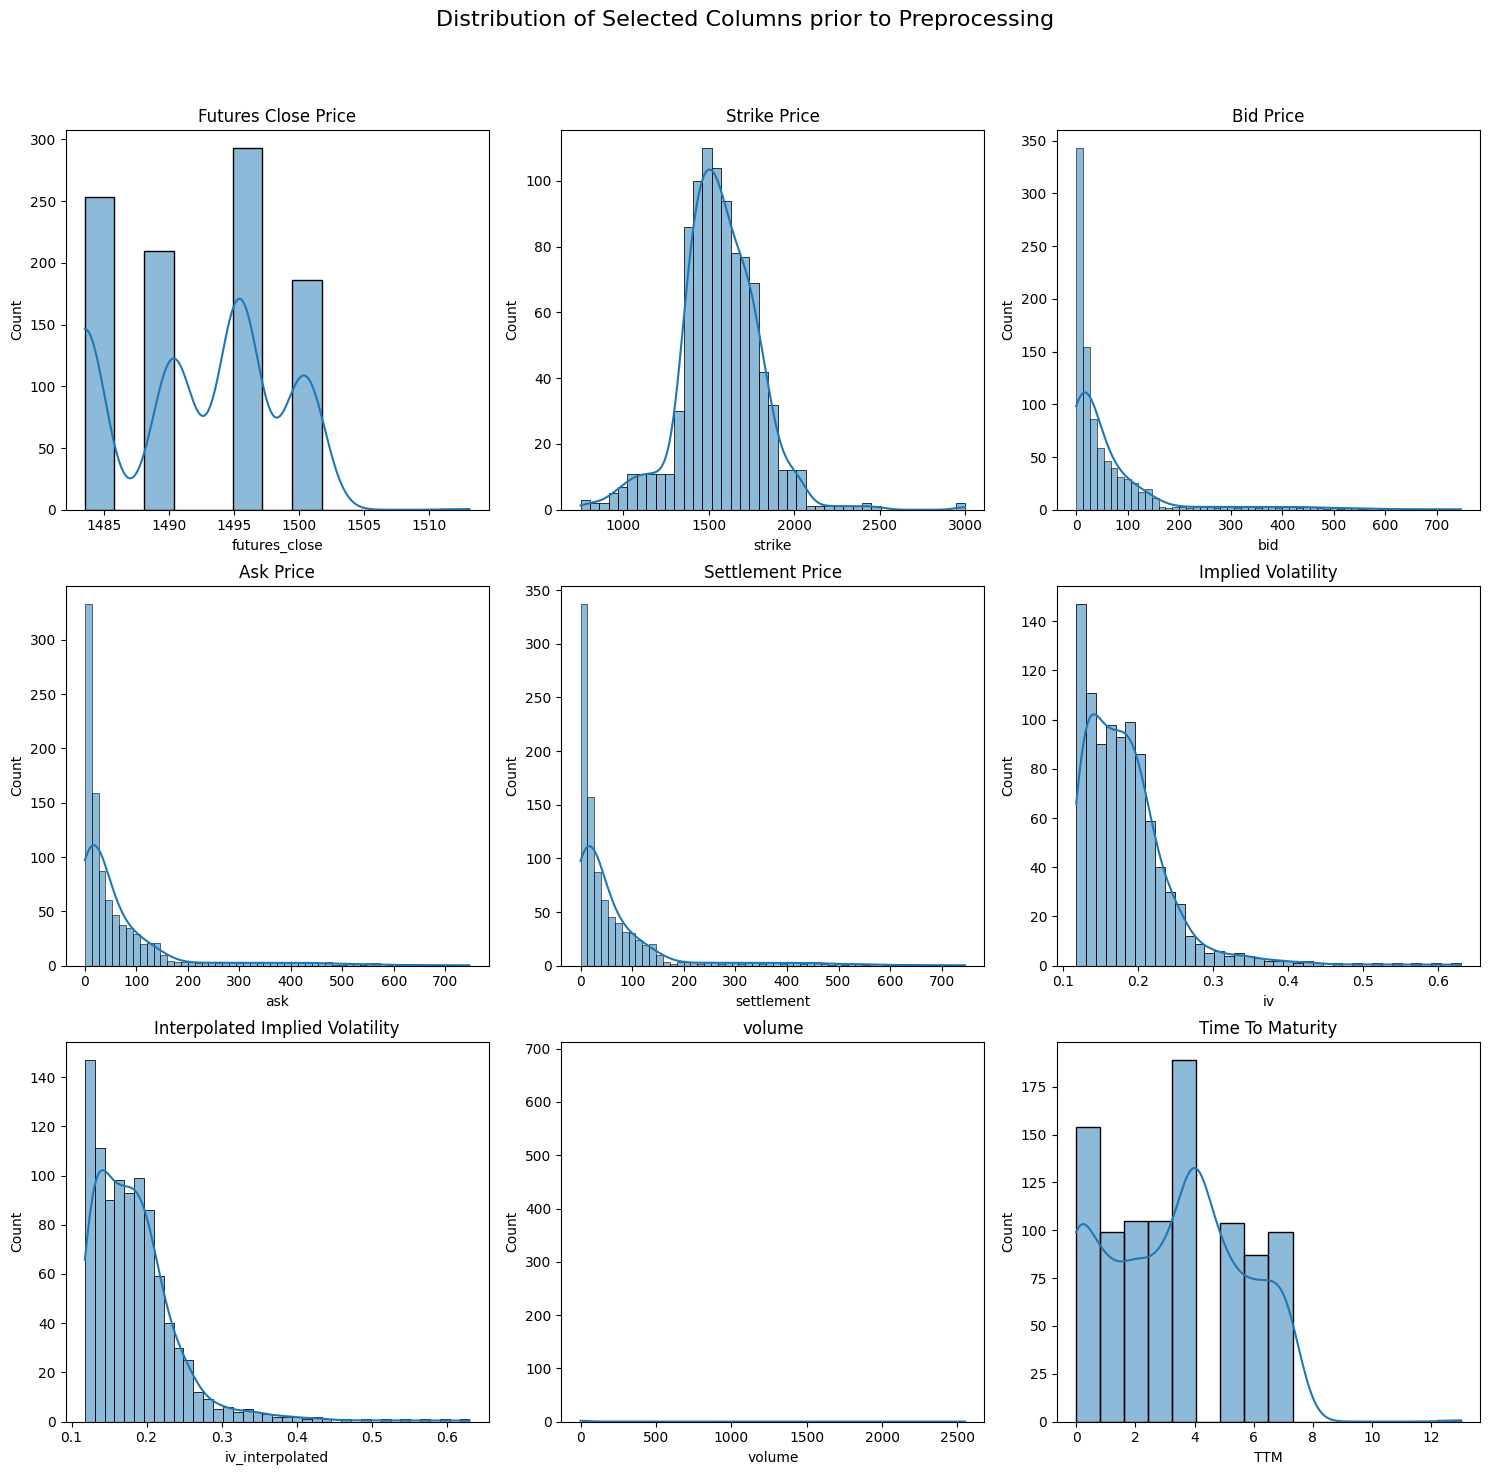

In [3]:
# Select the columns 
selected_columns = ['futures_close', 'strike', 'bid', 'ask', 'settlement', 'iv', 'iv_interpolated', 'volume', 'TTM']

# Create a 3x3 grid of scatter plots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Distribution of Selected Columns prior to Preprocessing', fontsize=16)

# Hardcode scatter plots for each feature
sns.histplot(data=df_real, x='futures_close', ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Futures Close Price')

sns.histplot(data=df_real, x='strike', ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Strike Price')

sns.histplot(data=df_real, x='bid', ax=axes[0, 2], kde=True)
axes[0, 2].set_title('Bid Price')

sns.histplot(data=df_real, x='ask', ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Ask Price')

sns.histplot(data=df_real, x='settlement', ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Settlement Price')

sns.histplot(data=df_real, x='iv', ax=axes[1, 2], kde=True)
axes[1, 2].set_title('Implied Volatility')

sns.histplot(data=df_real, x='iv_interpolated', ax=axes[2, 0], kde=True)
axes[2, 0].set_title('Interpolated Implied Volatility')

sns.histplot(data=df_real, x='volume', ax=axes[2, 1], kde=True)
axes[2, 1].set_title('volume')

sns.histplot(data=df_real, x='TTM', ax=axes[2, 2], kde=True)
axes[2, 2].set_title('Time To Maturity')

# Remove empty subplots if necessary
for i in range(len(selected_columns), 9):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Remove outliers

In [4]:
z_scores = stats.zscore(df_real)

# Define a threshold for Z-scores to identify outliers (e.g., Z-score > 3 or < -3)
threshold = 3

# Create a mask to identify outliers
outlier_mask = (abs(z_scores) < threshold).all(axis=1)

# Filter the DataFrame to remove outliers
df_real = df_real[outlier_mask]

# Select the columns to impute
columns_to_impute = ['futures_close', 'strike', 'bid', 'ask', 'settlement', 'iv', 'iv_interpolated', 'volume', 'TTM']

# Initialize the iterative imputer
imputer = IterativeImputer(max_iter=10, random_state=0)

# Fit and transform the imputer on the selected columns
df_real[columns_to_impute] = imputer.fit_transform(df_real[columns_to_impute])

# Save the preprocessed DataFrame
df_real.to_excel(r'C:\Users\koens\OneDrive\Bureaublad\Research-Practicum\Data\Real Data\FUT_Option_Preprocessed.xlsx', index=False)

### Normalize the data

In [5]:

# Separate the columns into price-related and volatility-related groups
price_columns = ['futures_close', 'strike', 'settlement']
bid_ask_columns = ['bid', 'ask']
volatility_columns = ['iv', 'iv_interpolated']
other_columns = ['volume']
ttm_columns = ['TTM']

# Normalize the price-related columns
price_scaler = MinMaxScaler()
price_normalized_data = price_scaler.fit_transform(df_real[price_columns])

# Normalize the volatility-related columns
volatility_scaler = MinMaxScaler()
volatility_normalized_data = volatility_scaler.fit_transform(df_real[volatility_columns])

# Normalize the bid-ask columns 
bid_ask_normalizer = MinMaxScaler()
bid_ask_normalized_data = bid_ask_normalizer.fit_transform(df_real[bid_ask_columns])

# Normalise the TTM column
ttm_normalizer = MinMaxScaler()
ttm_normalized_data = ttm_normalizer.fit_transform(df_real[ttm_columns])

# Combine the normalized data
data = pd.DataFrame({
    'futures_close': price_normalized_data[:, 0],
    'strike': price_normalized_data[:, 1],
    'bid': bid_ask_normalized_data[:, 0],
    'ask': bid_ask_normalized_data[:, 1],
    'settlement': price_normalized_data[:, 2],
    'iv': volatility_normalized_data[:, 0],
    'iv_interpolated': volatility_normalized_data[:, 1],
    'volume': df_real['volume'],
    'TTM': ttm_normalized_data[:, 0]
})


### Visualize the preprocessed data

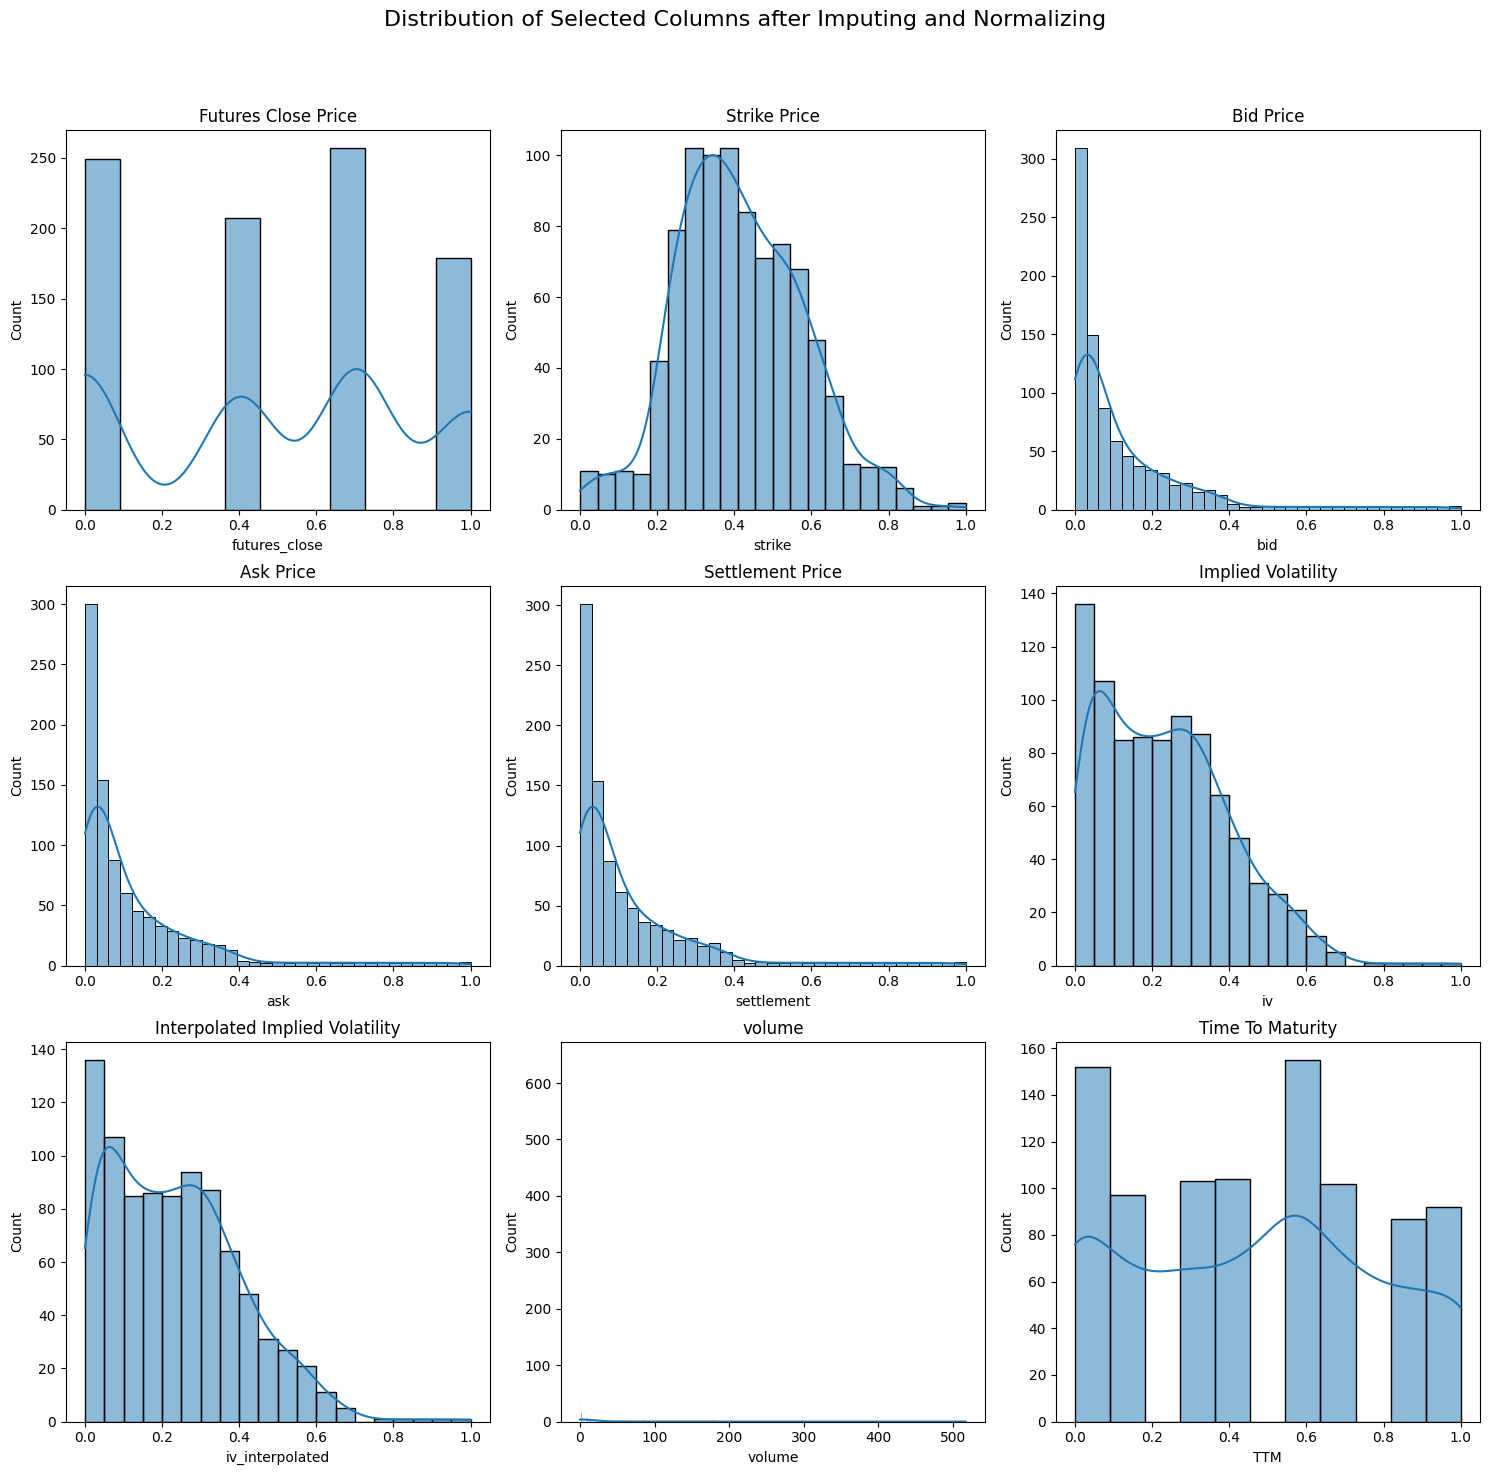

In [6]:
# Select the columns you want to visualize
selected_columns = ['futures_close', 'strike', 'bid', 'ask', 'settlement', 'iv', 'iv_interpolated', 'volume', 'TTM']

# Create a 3x3 grid of scatter plots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Distribution of Selected Columns after Imputing and Normalizing', fontsize=16)

# Hardcode scatter plots for each feature
sns.histplot(data=data, x='futures_close', ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Futures Close Price')

sns.histplot(data=data, x='strike', ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Strike Price')

sns.histplot(data=data, x='bid', ax=axes[0, 2], kde=True)
axes[0, 2].set_title('Bid Price')

sns.histplot(data=data, x='ask', ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Ask Price')

sns.histplot(data=data, x='settlement', ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Settlement Price')

sns.histplot(data=data, x='iv', ax=axes[1, 2], kde=True)
axes[1, 2].set_title('Implied Volatility')

sns.histplot(data=data, x='iv_interpolated', ax=axes[2, 0], kde=True)
axes[2, 0].set_title('Interpolated Implied Volatility')

sns.histplot(data=data, x='volume', ax=axes[2, 1], kde=True)
axes[2, 1].set_title('volume')

sns.histplot(data=data, x='TTM', ax=axes[2, 2], kde=True)
axes[2, 2].set_title('Time To Maturity')

# Remove empty subplots if necessary
for i in range(len(selected_columns), 9):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Build the Market Data Simulator

### Set the hyper parameters

In [13]:
# Load the input data
data_tensor = torch.tensor(data.values, dtype=torch.float32)

# Hyperparameters
input_dim = data_tensor.shape[1]
hidden_dim = 256
output_dim = data_tensor.shape[1]
batch_size = 128
learning_rate = 0.0002
epochs = 1000000
num_samples = len(data)

random_seed = 123
torch.manual_seed(random_seed)

# Set an output path 
output_path = r"C:\Users\koens\OneDrive\Bureaublad\Research-Practicum\Data"
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_file_name = f"test_synthetic_gold_pytorch_{timestamp}_{epochs}.xlsx"
output_path = f"{output_path}\\Synthetic Data\\{output_file_name}"

### Build the Discriminator and Generator

In [14]:
# Define the generator network
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()  
        )

    def forward(self, x):
        return self.model(x)

# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),  
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()  
        )

    def forward(self, x):
        return self.model(x)

### Define the GAN

In [15]:
# Create generator and discriminator instances
generator = Generator(input_dim, hidden_dim, output_dim)
discriminator = Discriminator(input_dim, hidden_dim, 1)

# Loss functions
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

### Train the GAN

In [16]:
start_time = time.time()

# Training loop
for epoch in range(epochs):
    # Sample noise for the generator
    noise = torch.randn(batch_size, input_dim)

    # Generate synthetic data
    fake_data = generator(noise)

    # Train the discriminator
    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)
    
    optimizer_D.zero_grad()
    real_output = discriminator(data_tensor[torch.randint(0, len(data), (batch_size,), dtype=torch.long)])
    fake_output = discriminator(fake_data.detach())
    real_loss = criterion(real_output, real_labels)
    fake_loss = criterion(fake_output, fake_labels)
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_D.step()

    # Train the generator
    optimizer_G.zero_grad()
    fake_output = discriminator(fake_data)
    g_loss = criterion(fake_output, real_labels)
    g_loss.backward()
    optimizer_G.step()

    # Calculate estimated time left
    current_time = time.time()
    elapsed_time = current_time - start_time
    time_per_epoch = elapsed_time / (epoch + 1)
    remaining_epochs = epochs - (epoch + 1)
    estimated_time_left_seconds = time_per_epoch * remaining_epochs
    estimated_time_left_minutes, estimated_time_left_seconds = divmod(estimated_time_left_seconds, 60)
    estimated_time_left_hours, estimated_time_left_minutes = divmod(estimated_time_left_minutes, 60)
    

    # Print progress
    clear_output(wait=True)
    display(f"Training status:...{((epoch + 1)/epochs)*100:.2f} %| Estimated remaining time: {int(estimated_time_left_hours)} hours and {int(estimated_time_left_minutes)} mins | Discriminator Loss: {d_loss.item():.6f} | Generator Loss: {g_loss.item():.6f}")

# Generate synthetic data
synthetic_data = generator(torch.randn(num_samples, input_dim)).detach().numpy()

# Convert the synthetic data back to a pandas DataFrame
df_synthetic = pd.DataFrame(synthetic_data, columns=data.columns)



'Training status:...100.00 %| Estimated remaining time: 0 hours and 0 mins | Discriminator Loss: 0.946639 | Generator Loss: 1.097271'

### De-normalize the synthetic data and save the data

In [17]:
# Denormalize the synthetic data using the inverse transform
df_synthetic = df_synthetic.copy()  # Create a copy to keep the original synthetic data intact

# Denormalize the price-related columns
df_synthetic[price_columns] = price_scaler.inverse_transform(df_synthetic[price_columns])

# Denormalize the volatility-related columns
df_synthetic[volatility_columns] = volatility_scaler.inverse_transform(df_synthetic[volatility_columns])

# Denormalize the bid-ask columns
df_synthetic[bid_ask_columns] = bid_ask_normalizer.inverse_transform(df_synthetic[bid_ask_columns])

# Denormalize the TTM column
df_synthetic[ttm_columns] = ttm_normalizer.inverse_transform(df_synthetic[ttm_columns])

# Save
df_synthetic.to_excel(output_path, index=False)

### Plot features

In [18]:
# Get the data
simulated_data_df = df_synthetic

# Add moneyness
simulated_data_df['Moneyness'] = simulated_data_df['strike']/simulated_data_df['futures_close']

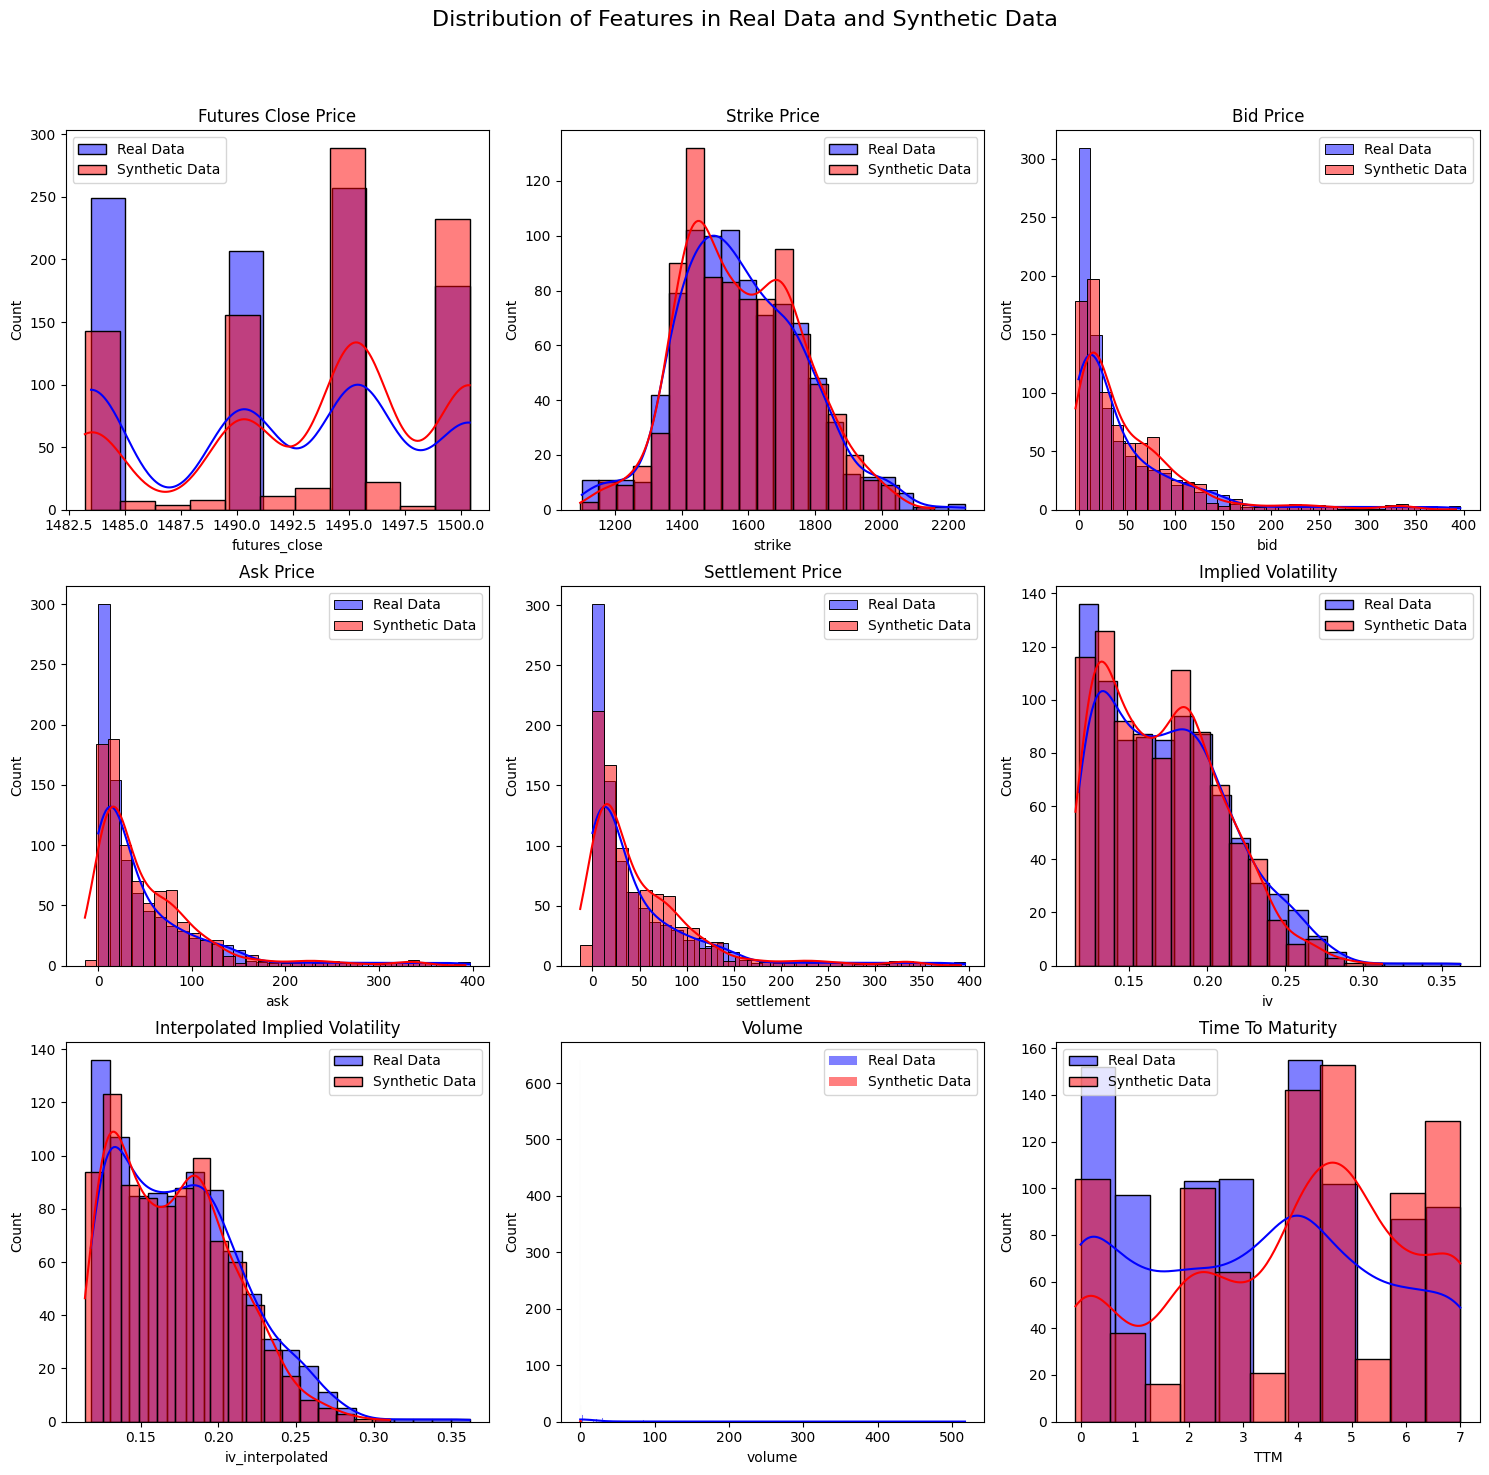

In [19]:
# Select the columns you want to visualize
selected_columns = ['futures_close', 'strike', 'bid', 'ask', 'settlement', 'iv', 'iv_interpolated', 'volume', 'TTM']

# Create a 3x3 grid of scatter plots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Distribution of Features in Real Data and Synthetic Data', fontsize=16)

# Hardcode scatter plots for each feature with histograms
sns.histplot(data=df_real, x='futures_close', ax=axes[0, 0], kde=True, color='blue', label='Real Data')
sns.histplot(data=df_synthetic, x='futures_close', ax=axes[0, 0], kde=True, color='red', label='Synthetic Data')
axes[0, 0].set_title('Futures Close Price')
axes[0, 0].legend()

sns.histplot(data=df_real, x='strike', ax=axes[0, 1], kde=True, color='blue', label='Real Data')
sns.histplot(data=df_synthetic, x='strike', ax=axes[0, 1], kde=True, color='red', label='Synthetic Data')
axes[0, 1].set_title('Strike Price')
axes[0, 1].legend()

sns.histplot(data=df_real, x='bid', ax=axes[0, 2], kde=True, color='blue', label='Real Data')
sns.histplot(data=df_synthetic, x='bid', ax=axes[0, 2], kde=True, color='red', label='Synthetic Data')
axes[0, 2].set_title('Bid Price')
axes[0, 2].legend()

sns.histplot(data=df_real, x='ask', ax=axes[1, 0], kde=True, color='blue', label='Real Data')
sns.histplot(data=df_synthetic, x='ask', ax=axes[1, 0], kde=True, color='red', label='Synthetic Data')
axes[1, 0].set_title('Ask Price')
axes[1, 0].legend()

sns.histplot(data=df_real, x='settlement', ax=axes[1, 1], kde=True, color='blue', label='Real Data')
sns.histplot(data=df_synthetic, x='settlement', ax=axes[1, 1], kde=True, color='red', label='Synthetic Data')
axes[1, 1].set_title('Settlement Price')
axes[1, 1].legend()

sns.histplot(data=df_real, x='iv', ax=axes[1, 2], kde=True, color='blue', label='Real Data')
sns.histplot(data=df_synthetic, x='iv', ax=axes[1, 2], kde=True, color='red', label='Synthetic Data')
axes[1, 2].set_title('Implied Volatility')
axes[1, 2].legend()

sns.histplot(data=df_real, x='iv_interpolated', ax=axes[2, 0], kde=True, color='blue', label='Real Data')
sns.histplot(data=df_synthetic, x='iv_interpolated', ax=axes[2, 0], kde=True, color='red', label='Synthetic Data')
axes[2, 0].set_title('Interpolated Implied Volatility')
axes[2, 0].legend()

sns.histplot(data=df_real, x='volume', ax=axes[2, 1], kde=True, color='blue', label='Real Data')
sns.histplot(data=df_synthetic, x='volume', ax=axes[2, 1], kde=True, color='red', label='Synthetic Data')
axes[2, 1].set_title('Volume')
axes[2, 1].legend()

sns.histplot(data=df_real, x='TTM', ax=axes[2, 2], kde=True, color='blue', label='Real Data')
sns.histplot(data=df_synthetic, x='TTM', ax=axes[2, 2], kde=True, color='red', label='Synthetic Data')
axes[2, 2].set_title('Time To Maturity')
axes[2, 2].legend()

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

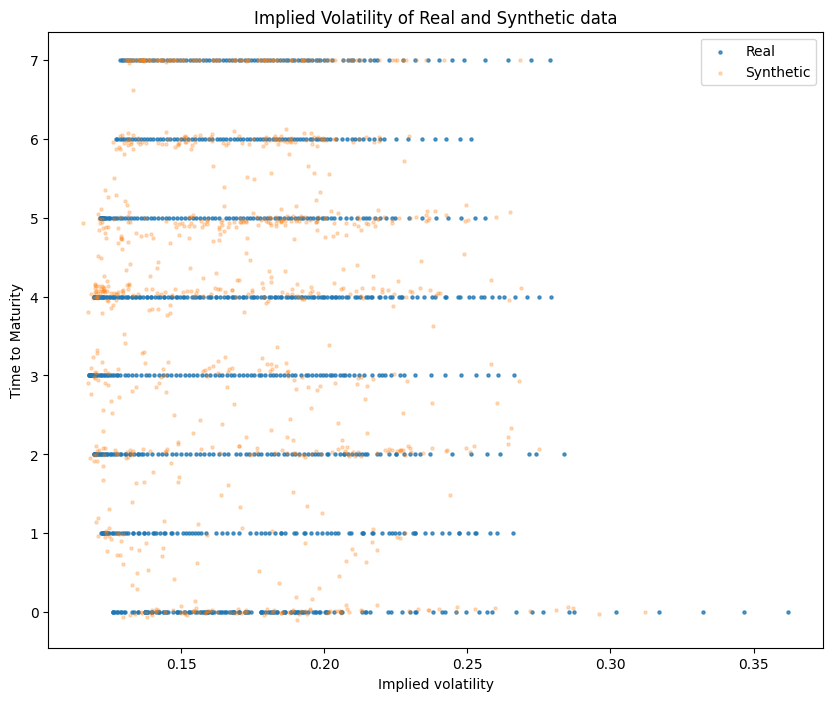

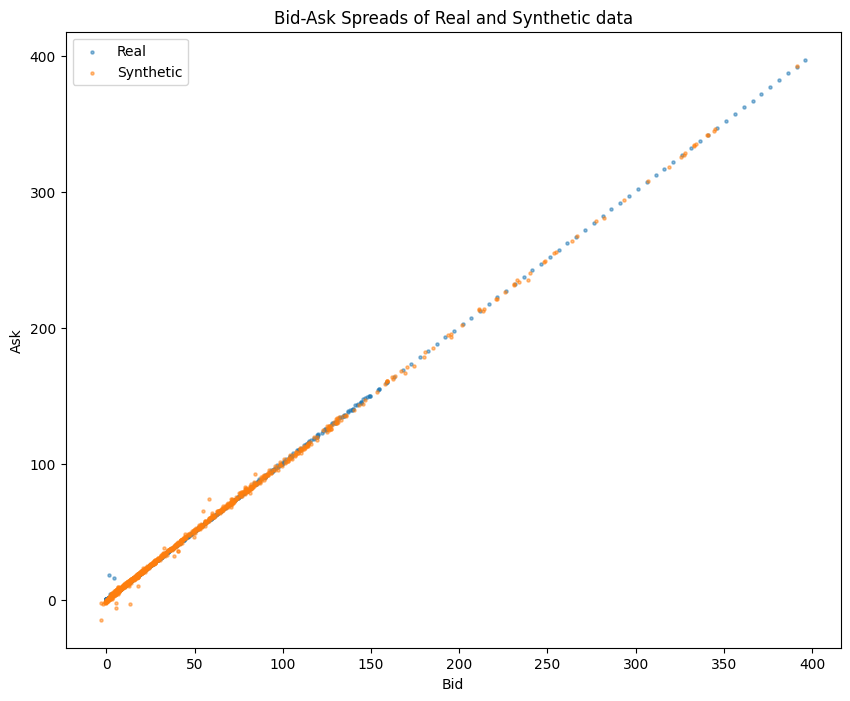

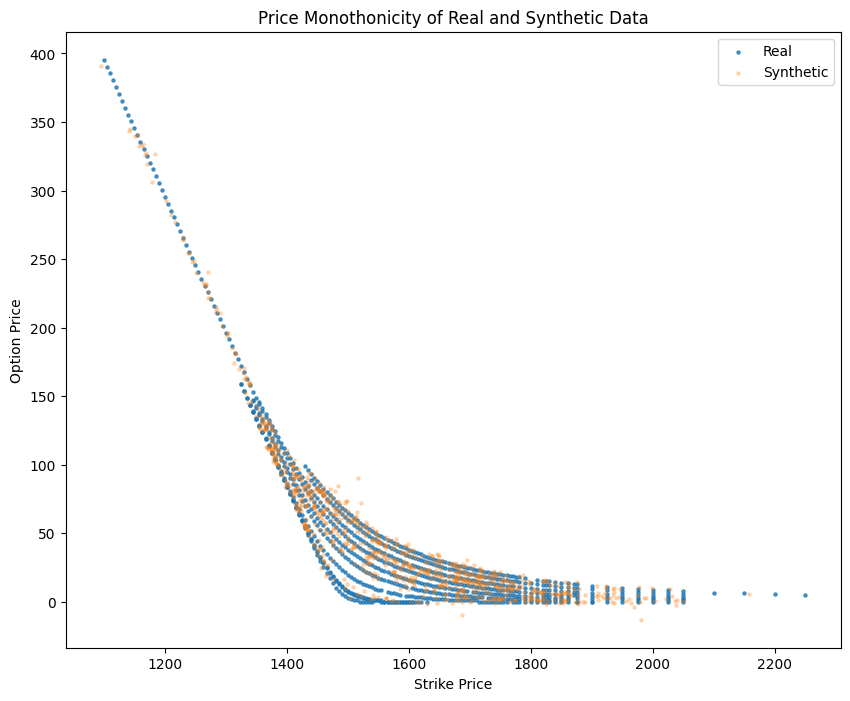

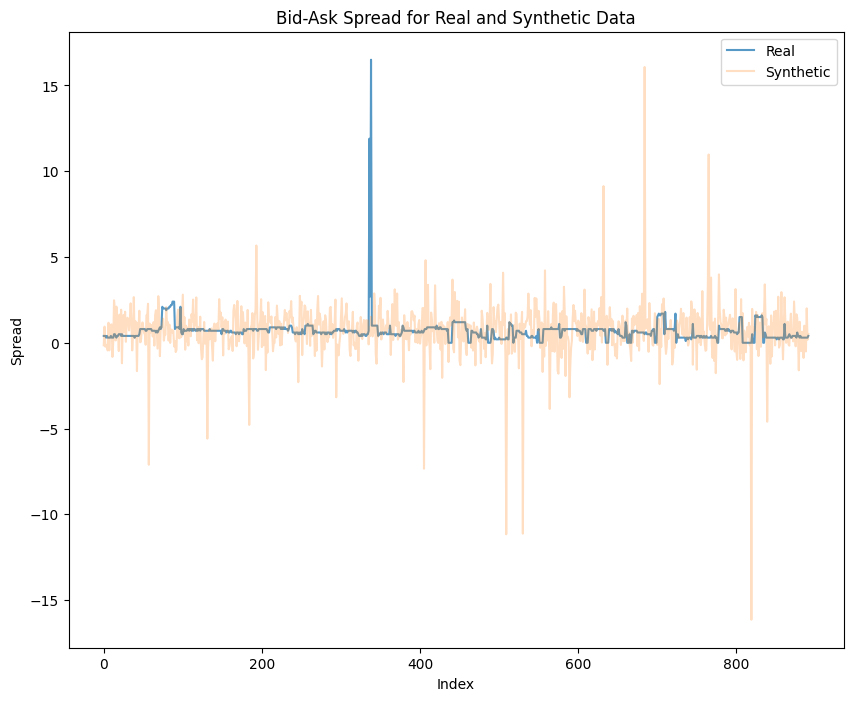

In [20]:
# Plot the implied volatility against the TTM in the first subplot
plt.scatter(df_real['iv'], df_real['TTM'], s=5, alpha=0.75, label="Real")
plt.scatter(df_synthetic['iv'], df_synthetic['TTM'], s=5, alpha=0.25, label="Synthetic")
plt.title("Implied Volatility of Real and Synthetic data")
plt.xlabel("Implied volatility")
plt.ylabel("Time to Maturity")
plt.legend()
plt.show()

# Plot the bid-ask spreads of both the real and simulated data in the second subplot
plt.scatter(df_real['bid'], df_real['ask'], s=5, alpha=0.5, label="Real")
plt.scatter(df_synthetic['bid'], df_synthetic['ask'], s=5, alpha=0.5, label="Synthetic")
plt.title("Bid-Ask Spreads of Real and Synthetic data")
plt.xlabel("Bid")
plt.ylabel("Ask")
plt.legend()
plt.show()

# Plot the option price and strike price of simulated data in the second subplot
plt.scatter(df_real['strike'], df_real['settlement'], s=5, alpha=0.75, label="Real")
plt.scatter(df_synthetic['strike'], df_synthetic['settlement'], s=5, alpha=0.25, label="Synthetic")
plt.title("Price Monothonicity of Real and Synthetic Data")
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.legend()
plt.show()

# Compute the bid ask spread in both dataframes
df_real = df_real.reset_index(drop=True)
df_real['spread'] = df_real['ask'] - df_real['bid']
df_synthetic['spread'] = df_synthetic['ask'] - df_synthetic['bid']

# Plot spread through time for both real and synthetic data
plt.figure() 
plt.plot(df_real['spread'], markersize = 2.5, alpha=0.75, label='Real')
plt.plot(df_synthetic['spread'], markersize = 2.5, alpha=0.25, label='Synthetic')
plt.title('Bid-Ask Spread for Real and Synthetic Data')
plt.xlabel('Index')
plt.ylabel('Spread')
plt.legend()
plt.show()

